**Part 3. AI Agent 심화 프로젝트**

- Chapter 03. GraphRAG

    - **📒[실습]** Clip 05. Vector 기반 GraphRAG 구현하기🗒️

## 🔗 Graph DB 연결하기

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j+s://d5b08997.databases.neo4j.io"
AUTH = ("neo4j", "<PASSWORD>")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

## 🔎 텍스트에서 Node, Relationships 추출하기

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

### 1️⃣ Text Split 하기

https://neo4j.com/docs/neo4j-graphrag-python/current/api.html#textsplitter

In [3]:
from neo4j_graphrag.experimental.components.types import TextChunks, TextChunk

text = """
Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
Also, Robin Williams.
"""

In [4]:
from langchain_text_splitters import CharacterTextSplitter
from neo4j_graphrag.experimental.components.text_splitters.langchain import LangChainTextSplitterAdapter
splitter = LangChainTextSplitterAdapter(
    CharacterTextSplitter(chunk_size=4000, chunk_overlap=200, separator=".")
)

In [5]:
chunks = await splitter.run(text=text)

In [6]:
chunks

TextChunks(chunks=[TextChunk(text='Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.\nAlso, Robin Williams.', index=0, metadata=None, uid='dde21cf5-017a-4e16-91f3-fde375179205')])

### 2️⃣ Text Chunk 임베딩 추가하기

`OpenAIEmbeddings()` : Defaults to “text-embedding-ada-002”

In [7]:
from neo4j_graphrag.experimental.components.embedder import TextChunkEmbedder
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

embedder = OpenAIEmbeddings()
chunk_embedder = TextChunkEmbedder(embedder)

In [8]:
chunks_with_embeddings = await chunk_embedder.run(text_chunks=chunks)

In [9]:
chunks_with_embeddings

TextChunks(chunks=[TextChunk(text='Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.\nAlso, Robin Williams.', index=0, metadata={'embedding': [-0.02531498856842518, 0.00015452291700057685, -0.0018970259698107839, -0.01334790326654911, -0.01656981185078621, 0.013104981742799282, -0.005254778079688549, 0.012414572760462761, -0.02283463068306446, -0.028485754504799843, 0.0162629634141922, 0.024215448647737503, 0.009243806824088097, -0.0050470163114368916, 

### 3️⃣ LLM으로 Node, Relationships 추출하기

In [10]:
from neo4j_graphrag.experimental.components.entity_relation_extractor import (
    LLMEntityRelationExtractor,
)
from neo4j_graphrag.llm import OpenAILLM

extractor = LLMEntityRelationExtractor(
    llm=OpenAILLM(
        model_name="gpt-4o",
        model_params={
            "max_tokens": 1000,
            "response_format": {"type": "json_object"},
        },
    )
)
extract_results = await extractor.run(chunks=chunks_with_embeddings)

In [11]:
extract_results

Neo4jGraph(nodes=[Neo4jNode(id='dde21cf5-017a-4e16-91f3-fde375179205', label='Chunk', properties={'text': 'Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.\nAlso, Robin Williams.', 'index': 0}, embedding_properties={'embedding': [-0.02531498856842518, 0.00015452291700057685, -0.0018970259698107839, -0.01334790326654911, -0.01656981185078621, 0.013104981742799282, -0.005254778079688549, 0.012414572760462761, -0.02283463068306446, -0.028485754504799843, 

In [12]:
# nodes
extract_results.nodes

[Neo4jNode(id='dde21cf5-017a-4e16-91f3-fde375179205', label='Chunk', properties={'text': 'Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\nShe was, in 1906, the first woman to become a professor at the University of Paris.\nAlso, Robin Williams.', 'index': 0}, embedding_properties={'embedding': [-0.02531498856842518, 0.00015452291700057685, -0.0018970259698107839, -0.01334790326654911, -0.01656981185078621, 0.013104981742799282, -0.005254778079688549, 0.012414572760462761, -0.02283463068306446, -0.028485754504799843, 0.016262963414192

In [13]:
# relationships
extract_results.relationships

[Neo4jRelationship(start_node_id='dde21cf5-017a-4e16-91f3-fde375179205:0', end_node_id='dde21cf5-017a-4e16-91f3-fde375179205:2', type='WON', properties={}, embedding_properties=None),
 Neo4jRelationship(start_node_id='dde21cf5-017a-4e16-91f3-fde375179205:1', end_node_id='dde21cf5-017a-4e16-91f3-fde375179205:2', type='WON', properties={}, embedding_properties=None),
 Neo4jRelationship(start_node_id='dde21cf5-017a-4e16-91f3-fde375179205:0', end_node_id='dde21cf5-017a-4e16-91f3-fde375179205:3', type='AFFILIATED_WITH', properties={}, embedding_properties=None),
 Neo4jRelationship(start_node_id='dde21cf5-017a-4e16-91f3-fde375179205:0', end_node_id='dde21cf5-017a-4e16-91f3-fde375179205', type='FROM_CHUNK', properties={}, embedding_properties=None),
 Neo4jRelationship(start_node_id='dde21cf5-017a-4e16-91f3-fde375179205:1', end_node_id='dde21cf5-017a-4e16-91f3-fde375179205', type='FROM_CHUNK', properties={}, embedding_properties=None),
 Neo4jRelationship(start_node_id='dde21cf5-017a-4e16-91f3-

### 4️⃣ GraphDB 적재하기

In [14]:
from neo4j_graphrag.experimental.components.kg_writer import Neo4jWriter
from neo4j_graphrag.experimental.components.types import Neo4jGraph

driver = GraphDatabase.driver(URI, auth=AUTH)

writer = Neo4jWriter(driver)
graph = Neo4jGraph(nodes=extract_results.nodes, relationships=extract_results.relationships)
await writer.run(graph)

KGWriterModel(status='SUCCESS', metadata={'node_count': 6, 'relationship_count': 8})

## 🧑‍💻 벡터 기반 RAG 구현하기

### 1️⃣ Vector INDEX 추가하기

```
CREATE VECTOR INDEX vectorchunk IF NOT EXISTS
FOR (c:Chunk)
ON c.embedding
OPTIONS { indexConfig: {
 `vector.dimensions`: 1536,
 `vector.similarity_function`: 'cosine'}
}
```

In [15]:
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "vectorchunk"
DIMENSION=1536

create_vector_index(
    driver,
    INDEX_NAME,
    label="Chunk",
    embedding_property="embedding",
    dimensions=DIMENSION,
    similarity_fn="cosine",
)

### 2️⃣ Vector Retriever 사용하기

In [16]:
import neo4j
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

retriever = VectorRetriever(driver, "vectorchunk", embedder=OpenAIEmbeddings())
    
retriever.search(query_text="Who is Marie Curie?", top_k=1)

RetrieverResult(items=[RetrieverResultItem(content="{'id': 'dde21cf5-017a-4e16-91f3-fde375179205', 'index': 0, 'text': 'Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\\nShe was, in 1906, the first woman to become a professor at the University of Paris.\\nAlso, Robin Williams.', 'embedding': None}", metadata={'score': 0.953857421875, 'nodeLabels': ['Chunk'], 'id': '4:5608432f-f330-4bd1-a5fd-776cf3d89c85:0'})], metadata={'query_vector': [-0.016120905056595802, 0.0011027329601347446, -0.007889791391789913, -0.011322704143822193, -0.02

### 3️⃣ GraphRAG 파이프라인 모듈 사용하기

In [17]:
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

retriever = VectorRetriever(driver, "vectorchunk", embedder=OpenAIEmbeddings())
llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever, llm)
response = graph_rag.search(query_text="Who is Marie Curie?", retriever_config={"top_k": 3}, return_context = True)

In [18]:
print(response.answer)

Marie Curie was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity. She was born on 7 November 1867 and passed away on 4 July 1934. Curie was the first woman to win a Nobel Prize, the first person to win it twice, and the only person to win Nobel Prizes in two different scientific fields. Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first married couple to win the Nobel Prize, thereby beginning the Curie family's legacy of five Nobel Prizes. Additionally, in 1906, she became the first woman to become a professor at the University of Paris.


In [19]:
print(response.retriever_result)

items=[RetrieverResultItem(content="{'id': 'dde21cf5-017a-4e16-91f3-fde375179205', 'index': 0, 'text': 'Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.\\nShe was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.\\nHer husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.\\nShe was, in 1906, the first woman to become a professor at the University of Paris.\\nAlso, Robin Williams.', 'embedding': None}", metadata={'score': 0.953857421875, 'nodeLabels': ['Chunk'], 'id': '4:5608432f-f330-4bd1-a5fd-776cf3d89c85:0'})] metadata={'query_vector': [-0.016120905056595802, 0.0011027329601347446, -0.007889791391789913, -0.011322704143822193, -0.022842325270175934,

## 사전구축 파이프라인 : SimpleKGPipeline

: 논문 PDF 에서 그래프 추출하고 GraphRAG 구현하기

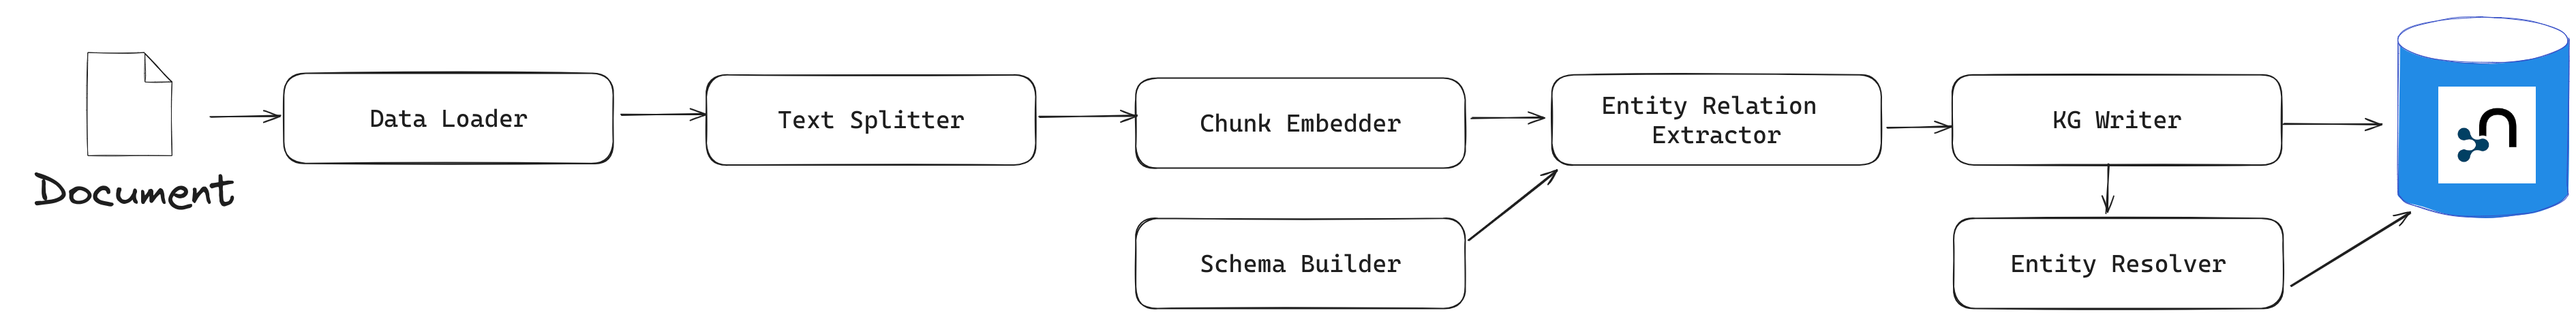

`pip install rapidfuzz spacy`

In [20]:
import neo4j
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

neo4j_driver = neo4j.GraphDatabase.driver(URI, auth=AUTH)

In [21]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM

llm = OpenAILLM(model_name="gpt-4o")

In [22]:
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

kg_builder = SimpleKGPipeline(
    llm=llm, # an LLMInterface for Entity and Relation extraction
    driver=neo4j_driver,  # a neo4j driver to write results to graph
    embedder=OpenAIEmbeddings(),  # an Embedder for chunks
    from_pdf=True,   # set to False if parsing an already extracted text
)
await kg_builder.run_async(file_path="GraphRAG.pdf")

LLM response has improper format for chunk_index=5


PipelineResult(run_id='80eb0b8c-7fb9-4056-8f16-2d73a0a7a254', result={'resolver': {'number_of_nodes_to_resolve': 405, 'number_of_created_nodes': 332}})

--> `그래프 적재 완료!`

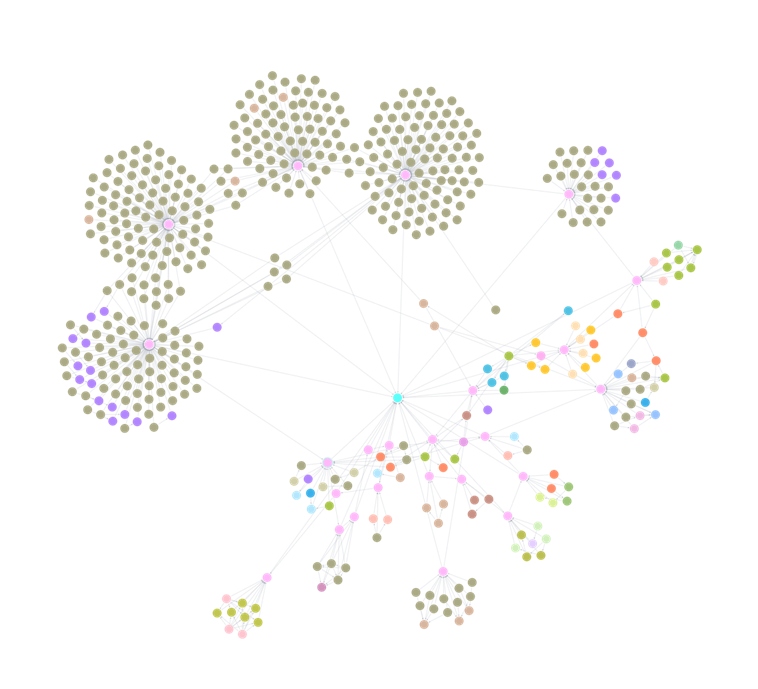

In [24]:
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "graphragchunk"
DIMENSION=1536

# Creating the index
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    create_vector_index(
        driver,
        INDEX_NAME,
        label="Chunk",
        embedding_property="embedding",
        dimensions=DIMENSION,
        similarity_fn="cosine",
    )

--> `벡터 인덱스 추가`

In [25]:
import neo4j
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.embeddings.openai import OpenAIEmbeddings

retriever = VectorRetriever(driver, "graphragchunk", embedder=OpenAIEmbeddings())
retriever.search(query_text="What is GraphRAG?", top_k=3)

RetrieverResult(items=[RetrieverResultItem(content="{'id': '9600ed14-4fd0-4d30-99f3-938ca3cd174f', 'index': 1, 'text': ' when the volume of data requires a RAG approach, since vector RAG\\napproaches are unable to support sensemaking over an entire corpus.\\nIn this paper, we presentGraphRAG – a graph-based RAG approach that enables sensemaking over\\nthe entirety of a large text corpus. GraphRAG first uses an LLM to construct a knowledge graph,\\nwhere nodes correspond to key entities in the corpus and edges represent relationships between those\\nentities. Next, it partitions the graph into a hierarchy of communities of closely related entities,\\nbefore using an LLM to generate community-level summaries. These summaries are generated in\\na bottom-up manner following the hierarchical structure of extracted communities, with summaries\\nat higher levels of the hierarchy recursively incorporating lower-level summaries. Together, these\\ncommunity summaries provide global descriptions 

In [26]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever, llm)

query_text = "What is GraphRAG?"
response = graph_rag.search(query_text=query_text, retriever_config={"top_k": 3}, return_context = True)
print(response.answer)

GraphRAG is a graph-based retrieval-augmented generation (RAG) approach designed to facilitate sensemaking across an entire large text corpus. Traditional vector RAG methods struggle with queries that require an overall understanding of a complete dataset. GraphRAG addresses this by first constructing a knowledge graph from the corpus using a large language model (LLM), where nodes represent key entities and edges depict their relationships. It then organizes the graph into a hierarchy of closely related community entities and generates community-level summaries in a bottom-up manner. These summaries, formed in a hierarchical manner, provide a comprehensive overview of the corpus. Queries are answered using a map-reduce process on these community summaries, which collectively produce a global response. GraphRAG significantly outperforms conventional vector RAG systems in handling global sensemaking questions, as demonstrated in its evaluation using GPT-4. It is available as open-source

In [27]:
print(response.retriever_result)

items=[RetrieverResultItem(content="{'id': '9600ed14-4fd0-4d30-99f3-938ca3cd174f', 'index': 1, 'text': ' when the volume of data requires a RAG approach, since vector RAG\\napproaches are unable to support sensemaking over an entire corpus.\\nIn this paper, we presentGraphRAG – a graph-based RAG approach that enables sensemaking over\\nthe entirety of a large text corpus. GraphRAG first uses an LLM to construct a knowledge graph,\\nwhere nodes correspond to key entities in the corpus and edges represent relationships between those\\nentities. Next, it partitions the graph into a hierarchy of communities of closely related entities,\\nbefore using an LLM to generate community-level summaries. These summaries are generated in\\na bottom-up manner following the hierarchical structure of extracted communities, with summaries\\nat higher levels of the hierarchy recursively incorporating lower-level summaries. Together, these\\ncommunity summaries provide global descriptions and insights ove

In [28]:
print(response.retriever_result.items[0].content[100:])

s a RAG approach, since vector RAG\napproaches are unable to support sensemaking over an entire corpus.\nIn this paper, we presentGraphRAG – a graph-based RAG approach that enables sensemaking over\nthe entirety of a large text corpus. GraphRAG first uses an LLM to construct a knowledge graph,\nwhere nodes correspond to key entities in the corpus and edges represent relationships between those\nentities. Next, it partitions the graph into a hierarchy of communities of closely related entities,\nbefore using an LLM to generate community-level summaries. These summaries are generated in\na bottom-up manner following the hierarchical structure of extracted communities, with summaries\nat higher levels of the hierarchy recursively incorporating lower-level summaries. Together, these\ncommunity summaries provide global descriptions and insights over the corpus. Finally, GraphRAG\nanswers queries through map-reduce processing of community summaries; in the map step, the\nsummaries are used t

## 임베딩 직접 추가하기

https://sandbox.neo4j.com/?usecase=stackoverflow

In [29]:
from neo4j_graphrag.embeddings.sentence_transformers import SentenceTransformerEmbeddings

In [30]:
embedder = SentenceTransformerEmbeddings(
    model="all-MiniLM-L6-v2",
)

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
driver = GraphDatabase.driver(URI, auth=AUTH)

with driver.session() as session:
    result = session.run("MATCH (q:Question) WHERE q.embedding IS NULL RETURN elementId(q) AS id, q.body_markdown AS text")
    records = result.data()

    for record in records:
        node_id = record["id"]
        text = record["text"]
        vector = embedder.embed_query(text)

        session.run("""
        MATCH (q) WHERE elementId(q) = $id
        SET q.embedding = $embedding
        """, {"id": node_id, "embedding": vector})


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: embedding)} {position: line: 1, column: 28, offset: 27} for query: 'MATCH (q:Question) WHERE q.embedding IS NULL RETURN elementId(q) AS id, q.body_markdown AS text'


In [32]:
from neo4j import GraphDatabase
from neo4j_graphrag.indexes import create_vector_index

INDEX_NAME = "questionindex"
DIMENSION=384

# Creating the index
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    create_vector_index(
        driver,
        INDEX_NAME,
        label="Question",
        embedding_property="embedding",
        dimensions=DIMENSION,
        similarity_fn="cosine",
    )

In [33]:
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

retriever = VectorRetriever(driver, "questionindex", embedder=embedder)
llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever, llm)
response = graph_rag.search(query_text="What are some possible questions that could arise under the topic 'Cypher - get all associated relationships for a node'?", return_context = True)

In [34]:
print(response.answer)

Some possible questions under the topic 'Cypher - get all associated relationships for a node' could include:

1. How do I retrieve all relationships connected to a specific node in Cypher?
2. What is the Cypher query syntax for obtaining both incoming and outgoing relationships of a node?
3. Can I filter relationships by type while querying all relationships for a node in Cypher?
4. How can I use Cypher to find nodes connected to a given node through specific types of relationships?
5. Is there a way to get all nodes and relationships directly or indirectly connected to a particular node in Neo4j using Cypher?
6. How can I visualize all the relationships associated with a node when using a graph database?
7. What performance considerations should I be aware of when retrieving all relationships for a heavily connected node in Neo4j?
8. How do I write a Cypher query to count all relationships a node is involved in?


In [35]:
print(response.retriever_result)

items=[RetrieverResultItem(content="{'creation_date': 1629293945, 'title': 'To get nodes and relationships between two specified nodes for review', 'link': 'https://stackoverflow.com/q/68833525', 'answer_count': 2, 'body_markdown': 'I have a database containing millions of nodes and edge data and I want to get all the nodes and relationships data between two specified nodes.\\r\\nBelow is the sample data for the graph which has 7 nodes and 7 relationships.\\r\\n \\r\\nTo traverse from 1st node to 7th node I can use the variable length relationship approach and can get the nodes and relationships in between the first and 7th nodes (but in this approach we need to know the number of relationships and nodes between 1st and 7th node). \\r\\nFor using variable length relationship approach we have to specify the number where we will get the end node and it traverses in one direction. \\r\\nBut in my case I know the start and end node and don&#39;t know how many relationships and nodes are in